In [4]:
!pip install -r requirements.txt

  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)

   ---------------------------------------- 0/3 [distro]
   ---------------------------------------- 0/3 [distro]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   ------------- -------------------------- 1/3 [groq]
   -------------------------- ------------- 2/3 [langchain-groq]
   ---------------------------------------- 3/3 [langchain-groq]



In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
import os
import voyageai

vo = voyageai.Client(api_key=os.environ.get("VOYAGE_API_KEY"),)

d:\Agentic rag\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
# self reflective
from langgraph.graph import StateGraph, END


In [14]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
pdf_path = r'C:\Users\User\Downloads\whatiscs.pdf'
loader = PyMuPDFLoader(pdf_path)


In [15]:
docs = loader.load()
docs[0]

Document(metadata={'producer': 'Acrobat Distiller 5.0.5 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2005-09-23T20:50:44-05:00', 'source': 'C:\\Users\\User\\Downloads\\whatiscs.pdf', 'file_path': 'C:\\Users\\User\\Downloads\\whatiscs.pdf', 'total_pages': 14, 'format': 'PDF 1.3', 'title': 'Microsoft Word - What_Is_CS.doc', 'author': 'hcc', 'subject': '', 'keywords': '', 'moddate': '2005-09-23T20:50:44-05:00', 'trapped': '', 'modDate': "D:20050923205044-05'00'", 'creationDate': "D:20050923205044-05'00'", 'page': 0}, page_content='1\nWHAT IS COMPUTER SCIENCE ALL ABOUT? \n \nH. Conrad Cunningham and Pallavi Tadepalli \nDepartment of Computer and Information Science \nUniversity of Mississippi \nCOMPUTERS EVERYWHERE \nAs scientific and engineering disciplines go, computer science is still quite young. \nAlthough the mathematical roots of computer science go back more than a thousand \nyears, it is only with the invention of the programmable electronic digital comput

In [16]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = splitter.split_documents(docs)

texts = [doc.page_content for doc in chunks]

In [7]:
texts

['1\nWHAT IS COMPUTER SCIENCE ALL ABOUT? \n \nH. Conrad Cunningham and Pallavi Tadepalli \nDepartment of Computer and Information Science \nUniversity of Mississippi \nCOMPUTERS EVERYWHERE \nAs scientific and engineering disciplines go, computer science is still quite young. \nAlthough the mathematical roots of computer science go back more than a thousand \nyears, it is only with the invention of the programmable electronic digital computer \nduring the World War II era of the 1930s and 1940s that the modern discipline of \ncomputer science began to take shape. As it has developed, computer science includes \ntheoretical studies, experimental methods, and engineering design all in one discipline. \n \nOne of the first computers was the ENIAC (Electronic Numerical Integrator and \nComputer), developed in the mid-1940s at the University of Pennsylvania. When \nconstruction was completed in 1946, the ENIAC cost about $500,000.  In today’s terms,',
 'construction was completed in 1946, th

In [20]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
import uuid

embeddings = vo.embed(texts, model="voyage-3", input_type="document").embeddings
collection_name = "pdf_docs"
embedding_dim = len(embeddings[0])

qdrant = QdrantClient(
    url=os.getenv("QDRANT_URL"), 
    api_key=os.getenv("QDRANT_API_KEY"),
)


if collection_name not in [c.name for c in qdrant.get_collections().collections]:
    qdrant.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
    )


points = []
for chunk, embedding in zip(chunks, embeddings):
    metadata = chunk.metadata or {}
    point = PointStruct(
        id=str(uuid.uuid4()),
        vector=embedding,
        payload={
            "text": chunk.page_content,
            "source": metadata.get("source", "unknown"),
            "page": metadata.get("page", None),
            "filename": metadata.get("file_name", pdf_path)
        }
    )
    points.append(point)

qdrant.upsert(collection_name=collection_name, points=points)

print(f"✅ {len(points)} chunks embedded and stored in Qdrant under '{collection_name}'")

✅ 40 chunks embedded and stored in Qdrant under 'pdf_docs'


In [ ]:
from typing import TypedDict, List, Optional

class GraphState(TypedDict):
    query: str
    documents: List[str]
    reranked_documents: List[str]
    answer: Optional[str]
    is_relevant: Optional[bool]
    retry_count: int
    final_answer: Optional[str]

In [ ]:
def retrieve_chunks(state: GraphState) -> GraphState:
    """Retrieve chunks using Voyage embeddings and Qdrant"""
    try:
        embedding = vo.embed([state['query']], model="voyage-3", input_type="query").embeddings[0]
        results = qdrant.search(collection_name=collection_name, query_vector=embedding, limit=8)
        
        # If no results found for out-of-context questions
        if not results:
            return {
                **state,
                "documents": ["No relevant information found in the knowledge base."]
            }
            
        return {
            **state,
            "documents": [r.payload['text'] for r in results]
        }
    except Exception as e:
        print(f"Error in retrieve_chunks: {e}")
        return {
            **state,
            "documents": ["Unable to retrieve information at this time."]
        }

In [115]:
def rerank(state: GraphState):
    reranking = vo.rerank(
        query=state['query'],
        documents=state['documents'],
        model="rerank-2-lite",
        top_k=4
    )
    reranked = [r.document for r in sorted(reranking.results, key=lambda r: r.relevance_score, reverse=True)]
    return {**state, "reranked_documents": reranked}

In [116]:
from pydantic import BaseModel, Field
from typing import List, Optional

class AnswerSchema(BaseModel):
    summary: str = Field(..., description="Detailed and comprehensive answer to the query")
    supporting_facts: List[str] = Field(..., description="Facts from the context supporting the summary")
    confidence_score: Optional[float] = Field(None, ge=0.0, le=1.0, description="Confidence score from 0 to 1")


In [ ]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_groq import ChatGroq
from langfuse.callback import CallbackHandler
import os

groq_api_key = os.environ['GROQ_API_KEY']
llm = ChatGroq(
    temperature=0.2,
    api_key=groq_api_key,
    model_name="llama3-8b-8192"
)

langfuse_handler = CallbackHandler(
    secret_key=os.environ.get("LANGFUSE_SECRET_KEY"),
    public_key=os.environ.get("LANGFUSE_PUBLIC_KEY"),
    host=os.environ.get("LANGFUSE_HOST")
)
langfuse_handler.auth_check()

parser = PydanticOutputParser(pydantic_object=AnswerSchema)

generation_prompt = PromptTemplate.from_template("""
Use the context below to answer the question. If unrelated, say you don't know.

Context:
{context}

Question: {query}
Your response must be formatted as a JSON object with the following keys:
1. "summary": A detailed answer to the question
2. "supporting_facts": A list of facts from the context that support your answer
3. "confidence_score": A number between 0 and 1 indicating your confidence

{format_instructions}
Answer (in JSON format):
DO NOT MENTION, "Here is your answer in JSON format as prefix in Answer
""")

generation_chain = generation_prompt | llm | parser

def generate(state):
    """Process the query and context to generate a structured answer"""
    context = "\n\n".join(state['reranked_documents'])
    
    try:
        result = generation_chain.invoke({
            "context": context,
            "query": state["query"],
            "format_instructions": parser.get_format_instructions()
        }, config={"callbacks": [langfuse_handler]})
        print("Type of result from generation_chain:", type(result))
        print("res::",result)
        return {**state, "answer": result.summary}
    except Exception as e:
        print(f"Error during generation: {e}")
        return {**state, "answer": "I encountered an issue processing your query. Please try rephrasing or providing more context."}

In [118]:
def get_final_answer(state: GraphState) -> str:
    """Determine the final answer based on relevance and retry attempts"""
    
    # If the answer was deemed relevant, return it as is
    if state["is_relevant"]:
        return state["answer"]
    
    # If not relevant even after retries, return a clear message
    if state["retry_count"] > 0:
        return f"I don't have enough information to answer your question about '{state['query']}' as it doesn't appear to be covered in the document, even after attempting to rephrase it. Please try asking something related to the content of the document."
    
    # If not relevant on first attempt
    return f"I don't have enough information to answer your question about '{state['query']}' as it doesn't appear to be covered in the document. Please try asking something related to the content of the document."


In [ ]:
relevance_prompt = PromptTemplate.from_template("""Is the following answer relevant and helpful to the question?

Question: {query}
Answer: {answer}

Respond with only 'yes' or 'no'.""")

judge_chain = relevance_prompt | llm

def check_relevance(state: GraphState):
    response = judge_chain.invoke({
        "query": state["query"],
        "answer": state["answer"]
    })
    response_text = response.content if hasattr(response, 'content') else str(response)
    
    relevant = "yes" in response_text.lower()
    
    updated_state = {**state, "is_relevant": relevant}
    
    final_answer = get_final_answer(updated_state)
    
    return {**updated_state, "final_answer": final_answer}


In [127]:
rephrase_prompt = PromptTemplate.from_template("""Rephrase the question to improve clarity for document search:

Original: {query}""")

rephrase_chain = rephrase_prompt | llm

def rephrase_and_retry(state: GraphState):
    response = rephrase_chain.invoke({"query": state["query"]})
    
    # Extract the text content from the AIMessage object
    if hasattr(response, 'content'):
        improved_query = response.content
    else:
        # Fallback to string conversion if it's already a string or other type
        improved_query = str(response)
    
    print(f"Original query: {state['query']}")
    print(f"Rephrased query: {improved_query}")
    
    return {
        **state,
        "query": improved_query,
        "retry_count": state["retry_count"] + 1
    }


In [121]:
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve_chunks)
workflow.add_node("rerank", rerank)
workflow.add_node("generate", generate)
workflow.add_node("judge", check_relevance)
workflow.add_node("rephrase", rephrase_and_retry)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "rerank")
workflow.add_edge("rerank", "generate")
workflow.add_edge("generate", "judge")

def judge_condition(state: GraphState) -> str:
    if not state["is_relevant"] and state["retry_count"] < 1:
        return "rephrase"
    else:
        return "__end__"

workflow.add_conditional_edges(
    "judge",
    judge_condition,
    path_map={"rephrase": "rephrase", "__end__": END}
)
workflow.add_edge("rephrase", "retrieve")
workflow.set_finish_point("judge")

rag_executor = workflow.compile()

In [123]:
query = "what is THE SCIENCE OF COMPUTING?"
result = rag_executor.invoke({
    "query": query,
    "documents": [],
    "reranked_documents": [],
    "answer": None,
    "is_relevant": None,
    "retry_count": 0,
    "final_answer": None
})

print("\nFinal Answer:\n", result["answer"])
print("\nWas it relevant?:", result["is_relevant"])
print("\nRetry attempts:", result["retry_count"])

C:\Users\User\AppData\Local\Temp\ipykernel_1408\2537296225.py:5: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant.search(collection_name=collection_name, query_vector=embedding, limit=8)


Type of result from generation_chain: <class '__main__.AnswerSchema'>
res:: summary='The Science of Computing is the rigorous study of processes, particularly those that can be carried out by computers. It involves understanding how to carry out a process methodically, describe what is done so that computers can execute it, and ensure that it is done correctly and efficiently.' supporting_facts=['The scientific (and practical) questions of interest include: How do we carry out a process methodically? How do we describe what we do so that computers can carry out the process? ... How do we do it efficiently? ...', 'The scientific activities of computer science include the study of processes and how processes can be represented as algorithms and programs.', 'The real-world problem might be an automated bakery, an adaptive traffic signal, a chess-playing computer, the special effects for the next blockbuster movie, or the operation of a global system to detect earthquakes and tsunamis.', '

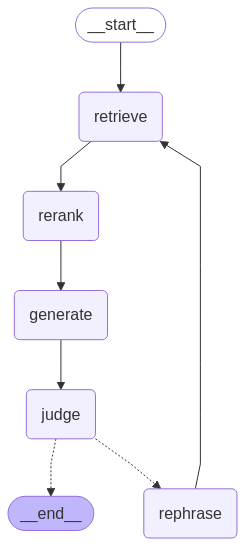

In [128]:
from IPython.display import Image, display
from langchain_core.runnables.graph import  MermaidDrawMethod

display(
    Image(
        rag_executor.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)